# **Installing And Importing Necessary Libraries**

In [1]:
pip install pymannkendall

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [2]:
pip install pmdarima

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.9/1.9 MB 71.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.9/9.9 MB 109.3 MB/s eta 0:00:00
  Attempting uninstall: statsmodels
    Found existing installation: statsmodels 0.12.2
    Uninstalling statsmodels-0.12.2:
      Successfully uninstalled statsmodels-0.12.2


In [3]:
pip install prophet

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly
import plotly.express as px
import pymannkendall as mk
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
import statsmodels.tsa.api as smt
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_squared_error
from statsmodels.tools.eval_measures import rmse
from pmdarima import auto_arima
from prophet import Prophet
from prophet.plot import plot_plotly, plot_components_plotly,add_changepoints_to_plot

# **Dataset**

In [5]:
df = pd.read_excel("/content/Airlines+Data.xlsx")
df

,Month,Passengers
0,1995-01-01,112
1,1995-02-01,118
2,1995-03-01,132
3,1995-04-01,129
4,1995-05-01,121
...,...,...
91,2002-08-01,405
92,2002-09-01,355
93,2002-10-01,306
94,2002-11-01,271


# **Problem Statement**

* Forecast the Airlines Passengers data set. Prepare a document for each model explaining how many dummy variables you have created and RMSE value for each model. Finally which model you will use for Forecasting.

# **EDA**

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 96 entries, 0 to 95
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   Month       96 non-null     datetime64[ns]
 1   Passengers  96 non-null     int64         
dtypes: datetime64[ns](1), int64(1)
memory usage: 1.6 KB


In [7]:
df.describe()

,Passengers
count,96.000000
mean,213.708333
std,71.918216
min,104.000000
25%,156.000000
50%,200.000000
75%,264.750000
max,413.000000


In [8]:
df.isnull().sum()

Month         0
Passengers    0
dtype: int64

In [9]:
df.set_index("Month", inplace=True)

# **Time Series**

---



In [10]:
fig = px.line(df)
fig.show()

# **Mann-Kendall Test - to detect Trend**

### **Hypothesis :**
>H0 : There is no Trend

>H1 : There is Trend

In [11]:
mk.original_test(df)

Mann_Kendall_Test(trend='increasing', h=True, p=0.0, z=11.16793132276346, Tau=0.7739035087719298, s=3529.0, var_s=99795.66666666667, slope=2.2142857142857144, intercept=94.82142857142857)

In [12]:
mk.original_test(df)[2]

0.0

### **Conclusion :**
* The p-value is less than 0.05, hence we reject H0 and conclude that the the trend is present in the data.

# **Augmented Dickey-fuller Test - to detect Stationarity**

### **Hypothesis:**
>H0 : The data is non-stationary

>H1 : The data is stationary

In [13]:
result = adfuller(df)
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])

ADF Statistic: 1.340248
p-value: 0.996825


###**Conclusion :**

* The p-value is more than 0.05, hence we do not reject H0 and conclude that the data is non-stationary.


# **Decomposition - to find the type of model**

* A rule of thumb for selecting the right model is to see in our plot if the trend and seasonal variation are relatively constant over time, in other words, linear. If yes, then we will select the Additive model. Otherwise, if the trend and seasonal variation increase or decrease over time then we use the Multiplicative model.




In [14]:
types = ["additive", "multiplicative"]
for i in types:
    print(f'{i} \n\n')
    seasonal_decomposition = seasonal_decompose(df, model = i , period=12)
    seasonal_decomposition_fig = seasonal_decomposition.plot()
    seasonal_decomposition_fig = plotly.tools.mpl_to_plotly(seasonal_decomposition_fig)
    seasonal_decomposition_fig.update_layout(width = 800, height = 700, title = i)
    seasonal_decomposition_fig.show()
    print("\n\n")

additive 







multiplicative 




### **Conclusion :**
For the Additive model, the residuals have a huge standard deviation, and also show a distinct pattern that an additive model didn’t capture. On the other hand, for the multiplicative model, the residuals are now centered around 1 and have a much lower range and standard deviation. Hence, our data follows a multiplicative model

# **Finding the order of differencing**

In [15]:
data = df
for i in range(1,20):
    series = data.diff()
    series = series.dropna()
    result = adfuller(series)
    p_value = result[1]
    data = series
    if p_value < 0.05:
        print("The order of which the data becomes stationary is : ",i)
        fig = px.line(data)
        fig.show()
        break  

The order of which the data becomes stationary is :  2


###**Conclusion:**
* Here, the graph shows that at the 2nd order differencing, the data becomes stationary and the trend is also gone, but to validate our results, we shall also perform the statistical test for testing stationarity and trend.

### **1. Mann-Kendall Test to detect Trend**

#### **Hypothesis :**
>H0 : There is no Trend

>H1 : There is Trend

In [16]:
mk.original_test(data)

Mann_Kendall_Test(trend='no trend', h=False, p=0.9713246636384092, z=-0.035946944624701355, Tau=-0.002745367192862045, s=-12.0, var_s=93640.0, slope=0.0, intercept=-1.0)

In [17]:
mk.original_test(data)[2]

0.9713246636384092

###**Conclusion :**
* The p-value is more than 0.05, hence we do not reject H0 and conclude that the the trend is not present in the data.

### **2. Augmented Dickey-fuller Test for Stationarity detection**

#### **Hypothesis:**
>H0 : The data is non-stationary

>H1 : The data is stationary

In [18]:
result = adfuller(data)
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])

ADF Statistic: -11.547981
p-value: 0.000000


###**Conclusion :**

The p-value is less than 0.05, hence we reject H0 and conclude that the data is stationary.


## **ACF and PACF plots**

/usr/local/lib/python3.8/dist-packages/statsmodels/graphics/tsaplots.py:348: FutureWarning:

The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.



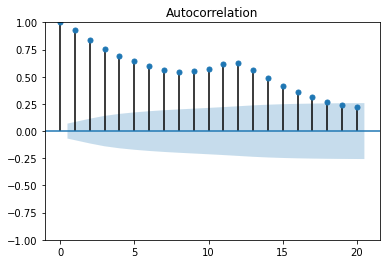

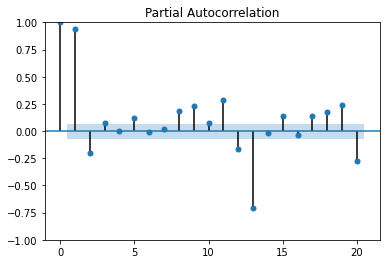

In [19]:
acf = smt.graphics.plot_acf(df, lags=20, alpha=0.5)
acf.show()
pacf = smt.graphics.plot_pacf(df, lags=20, alpha=0.5)
pacf.show()

## **Using Auto ARIMA for model building**

Here, in our data there is a serious problem of seasonality, hence we shall use SARIMAX model for forecasting. For that purpose we shall use Auto ARIMA.

In [20]:
auto_arima_model = auto_arima(df, start_p=1, start_q=1,
                      test='adf',       # use adftest to find optimal 'd'
                      max_p=3, max_q=3, # maximum p and q
                      m=12,              # periodicity=4
                      d=None,           # let model determine 'd'
                      seasonal=True,   # Seasonality
                      trace=True,
                      error_action='ignore',  
                      suppress_warnings=True, 
                      stepwise=True)

print(auto_arima_model.summary())

Performing stepwise search to minimize aic
 ARIMA(1,1,1)(1,1,1)[12]             : AIC=619.334, Time=0.37 sec
 ARIMA(0,1,0)(0,1,0)[12]             : AIC=622.012, Time=0.03 sec
 ARIMA(1,1,0)(1,1,0)[12]             : AIC=615.965, Time=0.08 sec
 ARIMA(0,1,1)(0,1,1)[12]             : AIC=616.628, Time=0.12 sec
 ARIMA(1,1,0)(0,1,0)[12]             : AIC=618.192, Time=0.03 sec
 ARIMA(1,1,0)(2,1,0)[12]             : AIC=617.814, Time=0.20 sec
 ARIMA(1,1,0)(1,1,1)[12]             : AIC=617.881, Time=0.17 sec
 ARIMA(1,1,0)(0,1,1)[12]             : AIC=616.531, Time=0.12 sec
 ARIMA(1,1,0)(2,1,1)[12]             : AIC=inf, Time=1.17 sec
 ARIMA(0,1,0)(1,1,0)[12]             : AIC=618.221, Time=0.06 sec
 ARIMA(2,1,0)(1,1,0)[12]             : AIC=617.862, Time=0.10 sec
 ARIMA(1,1,1)(1,1,0)[12]             : AIC=617.462, Time=0.12 sec
 ARIMA(0,1,1)(1,1,0)[12]             : AIC=616.076, Time=0.08 sec
 ARIMA(2,1,1)(1,1,0)[12]             : AIC=619.394, Time=0.25 sec
 ARIMA(1,1,0)(1,1,0)[12] intercept   

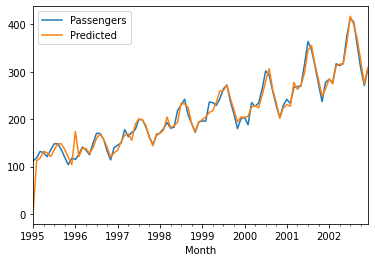

In [21]:
# making predictions
pred_auto = auto_arima_model.predict_in_sample(df)
df.plot(legend=True)
pred_auto.plot(label="Predicted",legend=True)
plt.show()

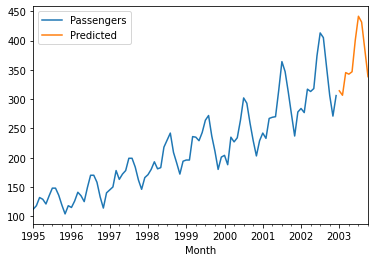

In [22]:
# making future predictions
fut_pred_auto = auto_arima_model.predict(n_periods=10)
df.plot(legend=True)
fut_pred_auto.plot(label="Predicted",legend=True)
plt.show()

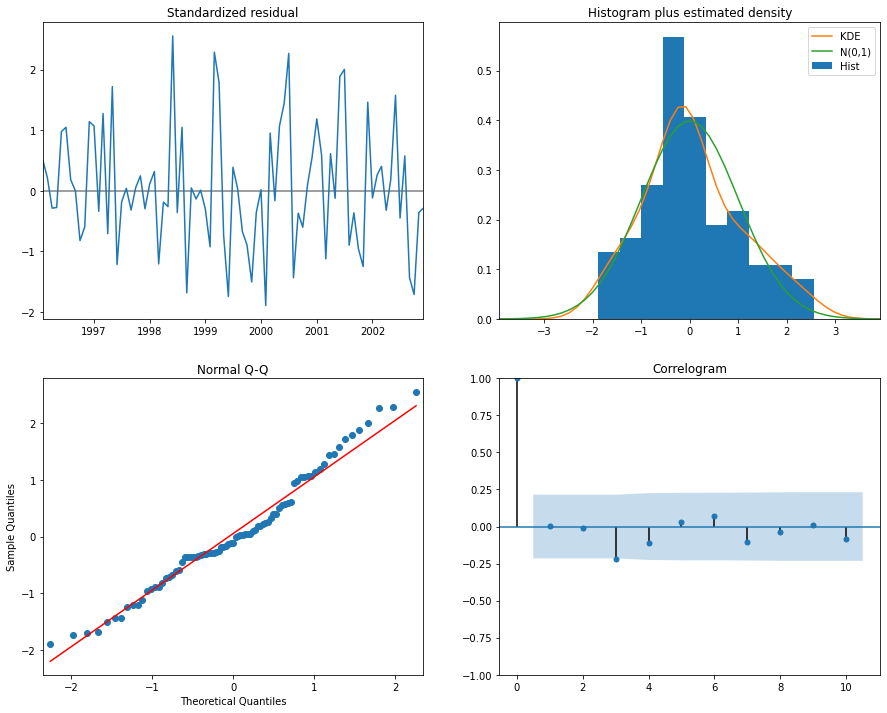

In [23]:
auto_arima_model.plot_diagnostics(figsize=(15, 12))
plt.show()

## **FB Prophet** - for building the forecasting model

In [24]:
data1 = df.reset_index()

In [25]:
train_dataset= pd.DataFrame()
train_dataset['ds'] = data1['Month']
train_dataset['y']= data1['Passengers']

In [26]:
m = Prophet()
m.fit(train_dataset)
future = m.make_future_dataframe(periods=14, freq='MS')
forecast = m.predict(future)
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']]

INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpq4hl3dp8/1_yjshep.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpq4hl3dp8/xqtsq7oa.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=75057', 'data', 'file=/tmp/tmpq4hl3dp8/1_yjshep.json', 'init=/tmp/tmpq4hl3dp8/xqtsq7oa.json', 'output', 'file=/tmp/tmpq4hl3dp8/prophet_model863mv9tm/prophet_model-20230110162229.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
16:22:29 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
16:22:29 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


,ds,yhat,yhat_lower,yhat_upper
0,1995-01-01,93.047369,76.513274,109.524632
1,1995-02-01,91.857989,75.098121,107.897081
2,1995-03-01,124.543183,108.819186,140.343638
3,1995-04-01,119.880127,105.546378,136.914013
4,1995-05-01,116.894670,102.057267,132.609395
...,...,...,...,...
105,2003-10-01,361.485855,345.360600,376.984015
106,2003-11-01,338.076766,322.448652,356.193319
107,2003-12-01,360.330712,343.325329,377.013961
108,2004-01-01,367.900087,351.442312,385.356680


In [27]:
plot_plotly(m , forecast)

In [28]:
plot_components_plotly(m,forecast)

INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpq4hl3dp8/8ebpm9ku.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpq4hl3dp8/oeg9qiei.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=60817', 'data', 'file=/tmp/tmpq4hl3dp8/8ebpm9ku.json', 'init=/tmp/tmpq4hl3dp8/oeg9qiei.json', 'output', 'file=/tmp/tmpq4hl3dp8/prophet_modelpjehsiur/prophet_model-20230110162230.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
16:22:30 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
16:22:30 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


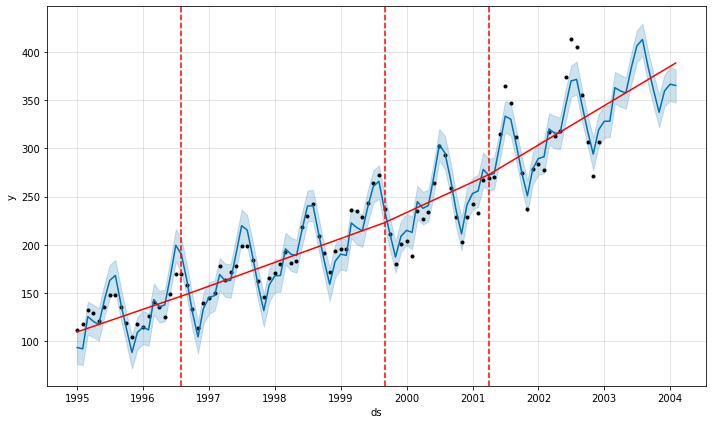

In [29]:
pro_change= Prophet(n_changepoints=4)
forecast = pro_change.fit(train_dataset).predict(future)
fig= pro_change.plot(forecast);
a = add_changepoints_to_plot(fig.gca(), pro_change, forecast)